**Get the pre-compiled binaries and setup environment**

In [1]:
!wget -q -O setup.py https://raw.githubusercontent.com/swieca22/swieca22/master/setup.py
import setup
setup.install_packages()

Loading libs... ✔️
Welcome to JupyROOT 6.22/08
All done! 🚀


## Generating mesh with gmsh

In [2]:
import numpy as np
import gmsh

occ = gmsh.model.occ
gmsh.initialize()

In [3]:
# Lenght in cm
pitch = 140e-4
hole_diameter = 70e-4
conductor_thickness = 5e-4
dielectric_thickness = 50e-4

In [4]:
# Create dielectric box

dielectric_origin = [-pitch/2, -pitch/2, -dielectric_thickness/2]
dielectric_size = [pitch, pitch, dielectric_thickness]

dielectric_id = occ.addBox(dielectric_origin[0], dielectric_origin[1], dielectric_origin[2],
                       dielectric_size[0], dielectric_size[1], dielectric_size[2])

In [5]:
# Create conductor box

detector_thickness = conductor_thickness + dielectric_thickness
conductor_origin = [-pitch/2, -pitch/2, -detector_thickness/2]
conductor_size = [pitch, pitch, detector_thickness]

conductor_id = occ.addBox(conductor_origin[0], conductor_origin[1], conductor_origin[2],
                       conductor_size[0], conductor_size[1], conductor_size[2])

In [6]:
# Create hole volume
hole_origin = [0, 0, -detector_thickness/2]
hole_length = [0, 0, detector_thickness]
hole_id = occ.addCylinder(hole_origin[0], hole_origin[1], hole_origin[2],
                       hole_length[0], hole_length[1], hole_length[2],
                       hole_diameter/2)

In [7]:
# Cut conductor box using dielectric volume

conductor_tags = occ.cut([(3, conductor_id)], [(3, dielectric_id)], removeTool=False)[0]
conductor_tags

[(3, 4), (3, 5)]

In [8]:
# Make the detector hole, passing though dielectric and conductor layers

dielectric_tags = occ.cut([(3, dielectric_id)], [(3, hole_id)], removeTool=False)[0]
conductor_tags = occ.cut(conductor_tags, [(3, hole_id)], removeTool=True)[0]
print(dielectric_tags)
print(conductor_tags)

[(3, 1)]
[(3, 4), (3, 5)]


In [9]:
# Create encompassing gas volume
# Length in cm
gas_gap = 0.2 # distance between GEM surfaces and electrodes (cathode and anode)

gas_box_length = 2 * gas_gap + detector_thickness
gas_origin = [-pitch/2, -pitch/2, -gas_box_length/2]
gas_size = [pitch, pitch, gas_box_length]

gas_id = occ.addBox(gas_origin[0], gas_origin[1], gas_origin[2],
                    gas_size[0], gas_size[1], gas_size[2])

In [10]:
# Subtract the detector from the gas volume

gas_tags = occ.cut([(3, gas_id)], conductor_tags + dielectric_tags, removeTool=False)[0]
print(gas_tags)

[(3, 6)]


In [11]:
# Merge volume surfaces. Until now we defined independent volumes with independent surfaces.
# The following function will make sure they share common boundaries.
occ.removeAllDuplicates()

# gmsh will recreate all the entities in the removeAllDuplicates function and will try to assign the old tags to the new volumes, but this can fail.
# Check if the tags id remain the same, if not you will need to find out which tag is what
volumes_tags = occ.getEntities(dim=3)
print(volumes_tags)

occ.synchronize()

[(3, 1), (3, 4), (3, 5), (3, 6)]


In [12]:
# Defining physical volumes
def get_ids(tags):
    return [tag[1] for tag in tags]
    
dim = 3

gmsh.model.addPhysicalGroup(dim, get_ids(gas_tags), 1)
gmsh.model.addPhysicalGroup(dim, get_ids(dielectric_tags), 2)
gmsh.model.addPhysicalGroup(dim, get_ids(conductor_tags), 3)

3

In [13]:
# Defining physical surfaces, the ones we need to apply boundary conditions like the potentials
dim = 2
epsilon = 1e-6

# Conductor
side = pitch/2 + epsilon
height = detector_thickness/2 + epsilon

top_conductor = occ.getEntitiesInBoundingBox(-side, -side, 0,
                                             side,side, height,
                                             dim)
botton_conductor = occ.getEntitiesInBoundingBox(-side, -side, -height,
                                                side, side, 0,
                                                dim)

# Electrodes: cathode and anode
height = gas_box_length/2

top_gas = occ.getEntitiesInBoundingBox(-side, -side, height - epsilon, side,
                                       side, height + epsilon,
                                       dim)
botton_gas = occ.getEntitiesInBoundingBox(-side, -side, -height - epsilon,
                                          side, side, -height + epsilon,
                                          dim)

# Side surfaces
side = pitch/2
xmin = occ.getEntitiesInBoundingBox(-side -epsilon, -side -epsilon, -height -epsilon,
                                    -side + epsilon, side + epsilon, height + epsilon,
                                    dim)
xmax = occ.getEntitiesInBoundingBox(side -epsilon, -side -epsilon, -height -epsilon,
                                    side + epsilon, side + epsilon, height + epsilon,
                                    dim)

ymin = occ.getEntitiesInBoundingBox(-side -epsilon, -side -epsilon, -height -epsilon,
                                    side + epsilon, -side + epsilon, height + epsilon,
                                    dim)
ymax = occ.getEntitiesInBoundingBox(-side -epsilon, side -epsilon, -height -epsilon,
                                    side + epsilon, side + epsilon, height + epsilon,
                                    dim)

print(top_conductor)
print(botton_conductor)
print(top_gas)
print(botton_gas)
print(xmin)
print(xmax)
print(ymin)
print(ymax)

[(2, 42), (2, 45), (2, 55), (2, 56), (2, 57), (2, 58), (2, 59)]
[(2, 37), (2, 47), (2, 50), (2, 51), (2, 52), (2, 53), (2, 54)]
[(2, 69)]
[(2, 63)]
[(2, 43), (2, 50), (2, 55), (2, 60), (2, 65)]
[(2, 48), (2, 53), (2, 58), (2, 64), (2, 68)]
[(2, 44), (2, 51), (2, 56), (2, 61), (2, 67)]
[(2, 46), (2, 52), (2, 57), (2, 62), (2, 66)]


In [14]:
gmsh.model.addPhysicalGroup(dim, get_ids(top_gas), 1)
gmsh.model.addPhysicalGroup(dim, get_ids(top_conductor), 2)
gmsh.model.addPhysicalGroup(dim, get_ids(botton_conductor), 3)
gmsh.model.addPhysicalGroup(dim, get_ids(botton_gas), 4)

gmsh.model.addPhysicalGroup(dim, get_ids(xmin), 5)
gmsh.model.addPhysicalGroup(dim, get_ids(xmax), 6)
gmsh.model.addPhysicalGroup(dim, get_ids(ymin), 7)
gmsh.model.addPhysicalGroup(dim, get_ids(ymax), 8)

8

In [15]:
# Set overall mesh size
all_points = gmsh.model.getEntities(dim=0)
gmsh.model.mesh.set_size(all_points, 150e-4)

# Refining mesh around GEM conductors
conductor_points = gmsh.model.getBoundary(top_conductor + botton_conductor, False, False, True)
gmsh.model.mesh.set_size(conductor_points, 5e-4)

In [16]:
# Generating mesh

gmsh.option.setNumber("Mesh.ElementOrder", 2)
gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
gmsh.model.mesh.generate(3)
gmsh.write("gemcell.msh")
gmsh.write("gemcell.vtk")
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 53 (Line)
Info    : [ 10%] Meshing curve 55 (Line)
Info    : [ 10%] Meshing curve 58 (Line)
Info    : [ 10%] Meshing curve 59 (Line)
Info    : [ 10%] Meshing curve 60 (Circle)
Info    : [ 10%] Meshing curve 63 (Line)
Info    : [ 20%] Meshing curve 66 (Line)
Info    : [ 20%] Meshing curve 67 (Line)
Info    : [ 20%] Meshing curve 68 (Line)
Info    : [ 20%] Meshing curve 69 (Circle)
Info    : [ 20%] Meshing curve 70 (Line)
Info    : [ 30%] Meshing curve 71 (Line)
Info    : [ 30%] Meshing curve 72 (Line)
Info    : [ 30%] Meshing curve 73 (Line)
Info    : [ 30%] Meshing curve 74 (Line)
Info    : [ 30%] Meshing curve 75 (Line)
Info    : [ 40%] Meshing curve 76 (Line)
Info    : [ 40%] Meshing curve 77 (Line)
Info    : [ 40%] Meshing curve 78 (Line)
Info    : [ 40%] Meshing curve 79 (Circle)
Info    : [ 40%] Meshing curve 80 (Line)
Info    : [ 50%] Meshing curve 81 (Line)
Info    : [ 50%] Meshing curve 82 (Line)
Info    : [ 50%] Meshing cu

## Solving electric field with Elmer

In [17]:
!ElmerGrid 14 2 gemcell.msh


Starting program Elmergrid
Elmergrid reading in-line arguments
Output will be saved to file gemcell.

Elmergrid loading data:
-----------------------
Format chosen using the first line: $MeshFormat
Gmsh version is 2.2
Loading mesh in Gmsh format 2.0 from file gemcell.msh
Allocating for 144324 knots and 119023 elements.
Moving bulk elements to boundary elements
Leading bulk elementtype is 510
Trailing bulk elementtype is 306
There are 18640 (out of 119023) lower dimensional elements.
Node 77164 belongs to maximum of 54 elements
Found 6432 side elements that have two parents.
Found correctly 18640 side elements.
Parent elements were reordered up to index 100383.
Moved 100383 elements (out of 119023) to new positions
Successfully read the mesh from the Gmsh input file.
Using physical numbering of entities

Elmergrid creating and manipulating meshes:
-------------------------------------------

Elmergrid saving data with method 2:
-------------------------------------
Saving mesh in Elmer

In [18]:
def write_sif(deltaV, gas_gap, Edrift=250, Etrans=1e3):
    """
    deltaV: [V] Voltage through GEM
    gas_gap: [cm] Distance between GEM surfaces and electrodes (cathode and anode)
    Edrift: [V/cm] Drift field
    Etrans: [V/cm] Transfer field"""

    text=f"""
Check Keywords Warn

Header
  Mesh DB "." "gemcell"
End

Simulation
  Coordinate System = Cartesian 3D
  Simulation Type = Steady State
  Steady State Max Iterations = 1
  Output File = "gemcell.result"
  Post File = "gemcell.vtu"
End

Constants
  Permittivity Of Vacuum = 8.8542e-12
End

Body 1
  Equation = 1
  Material = 1
End

Body 2
  Equation = 1
  Material = 2
End

Body 3
  Equation = 1
  Material = 3
End

Equation 1
  Active Solvers(1) = 1
  Calculate Electric Energy = True
End

Solver 1
  Equation = Stat Elec Solver
  Variable = Potential
  Variable DOFs = 1
  Procedure = "StatElecSolve" "StatElecSolver"
  Calculate Electric Field = True
  Calculate Electric Flux = False
  Linear System Solver = Iterative
  Linear System Iterative Method = BiCGStab
  Linear System Max Iterations = 1000
  Linear System Abort Not Converged = True
  Linear System Convergence Tolerance = 1.0e-10
  Linear System Preconditioning = ILU1
  Steady State Convergence Tolerance = 5.0e-7
!  Adaptive Mesh Refinement = True
!  Adaptive Remesh = True
!  Adaptive Save Mesh = True
!  Adaptive Error Limit = 1.0e-12
End

! Gas
Material 1
  Relative Permittivity = 1
  Density = 1
End

! Dielectric
Material 2
  Relative Permittivity = 3.23
  Density = 2
End

! Conductor
Material 3
  Relative Permittivity = 1e10
  Density = 3
End

! Upper electrode
Boundary Condition 1
  Target Boundaries = 1
  Potential = {-1*Etrans*gas_gap - deltaV - Edrift*gas_gap}
End

! Upper copper plate
Boundary Condition 2
  Target Boundaries = 2
  Potential = {-1*Etrans*gas_gap - deltaV}
End

! Lower copper plate
Boundary Condition 3
  Target Boundaries = 3
  Potential = {-1*Etrans*gas_gap}
End

! Lower electrode
Boundary Condition 4
  Target Boundaries = 4
  Potential = 0
End

! Set up boundary xmin
Boundary Condition 5
  Target Boundaries = 5
End
! Link to xmax
Boundary Condition 6
  Target Boundaries = 6
  Periodic BC = 5
  Periodic BC Potential = Logical True
End

! Set up boundary for ymin
Boundary Condition 7
  Target Boundaries = 7
End
! Link to ymax
Boundary Condition 8
  Target Boundaries = 8
  Periodic BC = 7
  Periodic BC Potential = Logical True
End
"""

    with open("gemcell.sif", "w") as file:
        file.write(text)


In [19]:
write_sif(deltaV=450, gas_gap=gas_gap)

In [20]:
!ElmerSolver gemcell.sif

ELMER SOLVER (v 9.0) STARTED AT: 2022/07/19 19:05:12
ParCommInit:  Initialize #PEs:            1
MAIN: 
MAIN: =============================================================
MAIN: ElmerSolver finite element software, Welcome!
MAIN: This program is free software licensed under (L)GPL
MAIN: Copyright 1st April 1995 - , CSC - IT Center for Science Ltd.
MAIN: Webpage http://www.csc.fi/elmer, Email elmeradm@csc.fi
MAIN: Version: 9.0 (Rev: cdd726ff, Compiled: 2022-07-01)
MAIN:  Running one task without MPI parallelization.
MAIN:  Running with just one thread per task.
MAIN: =============================================================
MAIN: 
MAIN: 
MAIN: -------------------------------------
MAIN: Reading Model: gemcell.sif
LoadInputFile: Scanning input file: gemcell.sif
LoadInputFile: Scanning only size info
LoadInputFile: First time visiting
LoadInputFile: Reading base load of sif file
LoadInputFile: Loading input file: gemcell.sif
LoadInputFile: Reading base load of sif file
CheckKeyword:  

## Visualizing mesh and field with Garfield

Define the `pitch` variable in cm for this to work

In [21]:
import ROOT

with open("gemcell/dielectrics.dat", "w") as file:
    text = """3
1 1
2 3.23
3 1e10
"""
    file.write(text)

elm = ROOT.Garfield.ComponentElmer("gemcell/mesh.header", "gemcell/mesh.elements", "gemcell/mesh.nodes",
                                        "gemcell/dielectrics.dat", "gemcell/gemcell.result", "cm")
elm.EnablePeriodicityX()
elm.EnablePeriodicityY()

ComponentElmer::Initialise:
    Read 144324 nodes and 100383 elements from file gemcell/mesh.header.
ComponentElmer::Initialise:
    Set material 0 of 3 to eps 1.
ComponentElmer::Initialise:
    Set material 1 of 3 to eps 3.23.
ComponentElmer::Initialise:
    Set material 2 of 3 to eps 1e+10.
ComponentElmer::Initialise: Finished.
ComponentElmer::Prepare:
    Caching the bounding boxes of all elements... done.
ComponentElmer::InitializeTetrahedralTree: Success.


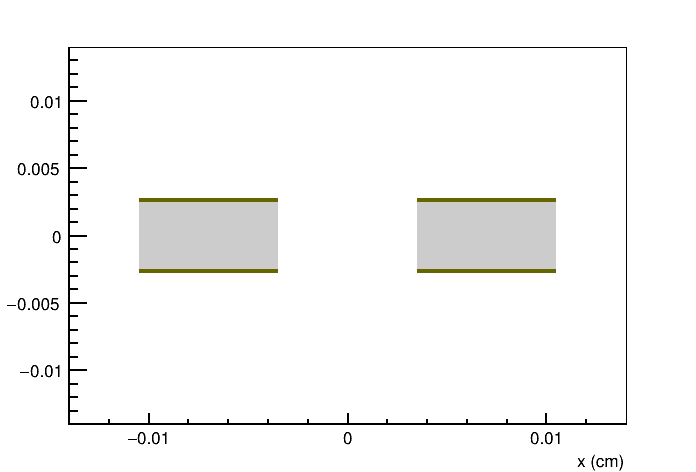

In [22]:
# Plot side geometry
cGeom = ROOT.TCanvas("geom", "Geometry")
viewMesh = ROOT.Garfield.ViewFEMesh()
viewMesh.SetCanvas(cGeom)
viewMesh.SetComponent(elm)
viewMesh.SetArea(-pitch, -pitch/2, -pitch, pitch, pitch/2, pitch)
viewMesh.SetPlane(0, -1, 0, 0, 0, 0)
viewMesh.SetFillMesh(True)
viewMesh.SetColor(1,ROOT.kGray)
viewMesh.SetColor(2,ROOT.kYellow + 3)
viewMesh.EnableAxes()
viewMesh.SetXaxisTitle("x (cm)")
viewMesh.SetYaxisTitle("z (cm)")
viewMesh.Plot()
cGeom.Draw()

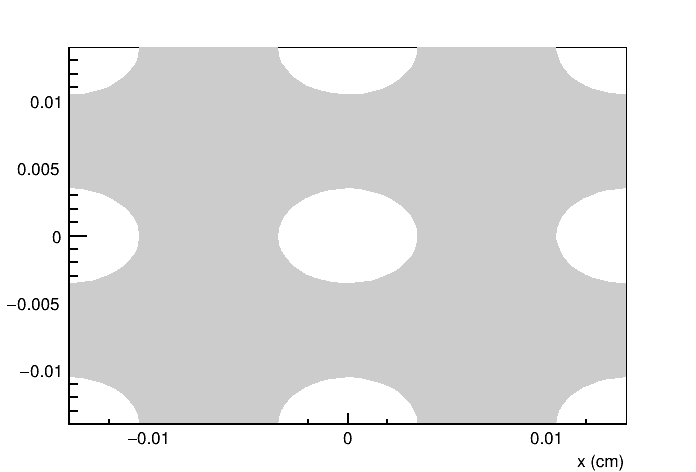

In [23]:
# Plot top geometry
viewMesh.SetArea(-pitch, -pitch, -pitch, pitch,  pitch, pitch)
viewMesh.SetPlane(0, 0, -1, 0, 0, 0)
viewMesh.SetXaxisTitle("x (cm)")
viewMesh.SetYaxisTitle("y (cm)")
viewMesh.Plot()
cGeom.Draw()

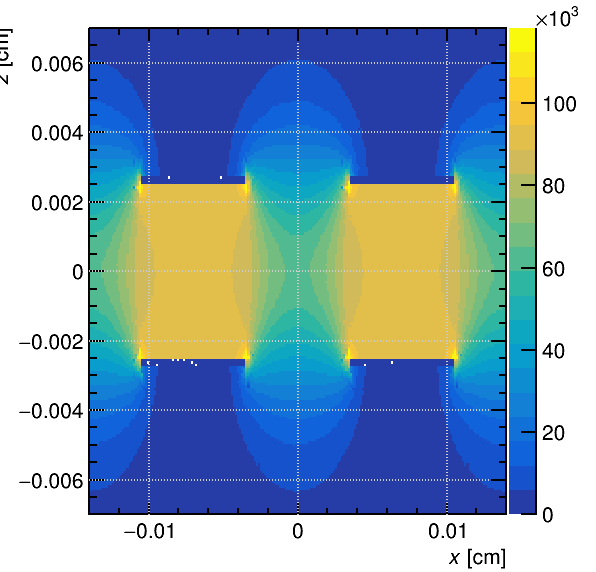

In [24]:
# Plot electric field magnitude
cFields = ROOT.TCanvas("fields", "Fields")
viewField = ROOT.Garfield.ViewField()
viewField.SetComponent(elm)
viewField.SetCanvas(cFields)
viewField.SetArea(-pitch, -pitch/2, pitch, pitch/2)
viewField.SetPlane(0, -1, 0, 0, 0, 0)
viewField.Plot("e", "colz")
cFields.Draw()